# Hand gesture recognition
This file contains code for deep learning model capable of classification of 20 different hand gestures based on black and white hand masks.

In [1]:
import os
import numpy as np
from PIL import Image
import tensorflow as tf
from keras import Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [2]:
import albumentations as A
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

### Train data

In [19]:
path ='train'

In [20]:
def load_images_from_folder(folder, target_size=(28, 28)):
    images = []
    classes = []
    classes_map = {}
    class_count = 0
    
    for subdir, _, files in os.walk(folder):
        for file in files:
            if file.endswith('.jpg'): 
                file_path = os.path.join(subdir, file)
                try:
                    img = Image.open(file_path).convert('L') # Convert to grayscale
                    img = img.resize(target_size)
                    images.append(np.array(img) / 255.0)

                    abstractClass = os.path.basename(subdir)
                    if abstractClass not in classes_map:
                        classes_map[abstractClass] = class_count
                        class_count += 1

                    classes.append(classes_map[abstractClass])
                except Exception as e:
                    print(f"Error loading image {file_path}: {e}")
    return np.array(images), np.array(classes), classes_map

In [21]:
x, y, classes_map = load_images_from_folder(path, target_size=(50, 50))

In [22]:
x_data = x.reshape(-1, 50, 50, 1)
y_data = to_categorical(y, len(classes_map))

### Split for train and validation data (used while training the model)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [28]:
y_train.shape

(14400, 20)

### Image augmentation
Thanks to it, the model will better generalize samples and learn recognition of gestures by different angles and offsets, so it might be more resistant to badly generated hand masks. 

In [28]:
 datagen = ImageDataGenerator(
    rotation_range=80,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant'
)

In [8]:
from keras.layers import BatchNormalization, Dropout, LayerNormalization, Add, MultiHeadAttention, GlobalAveragePooling2D

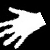

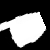

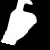

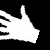

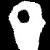

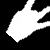

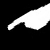

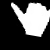

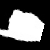

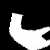

In [31]:
for _ in range(10):
    i = datagen.flow(x_train, batch_size=32)
    batch = next(i)
    display(Image.fromarray(np.array(batch)[0].squeeze()*255).convert("RGB"))

### Model declaration

In [7]:
def attention_block(x):
    query = Dense(x.shape[-1])(x)
    key = Dense(x.shape[-1])(x)
    value = Dense(x.shape[-1])(x)
    attention_output = MultiHeadAttention(num_heads=4, key_dim=x.shape[-1])(query, key, value)
    attention_output = Add()([x, attention_output]) 
    attention_output = LayerNormalization()(attention_output)
    return attention_output

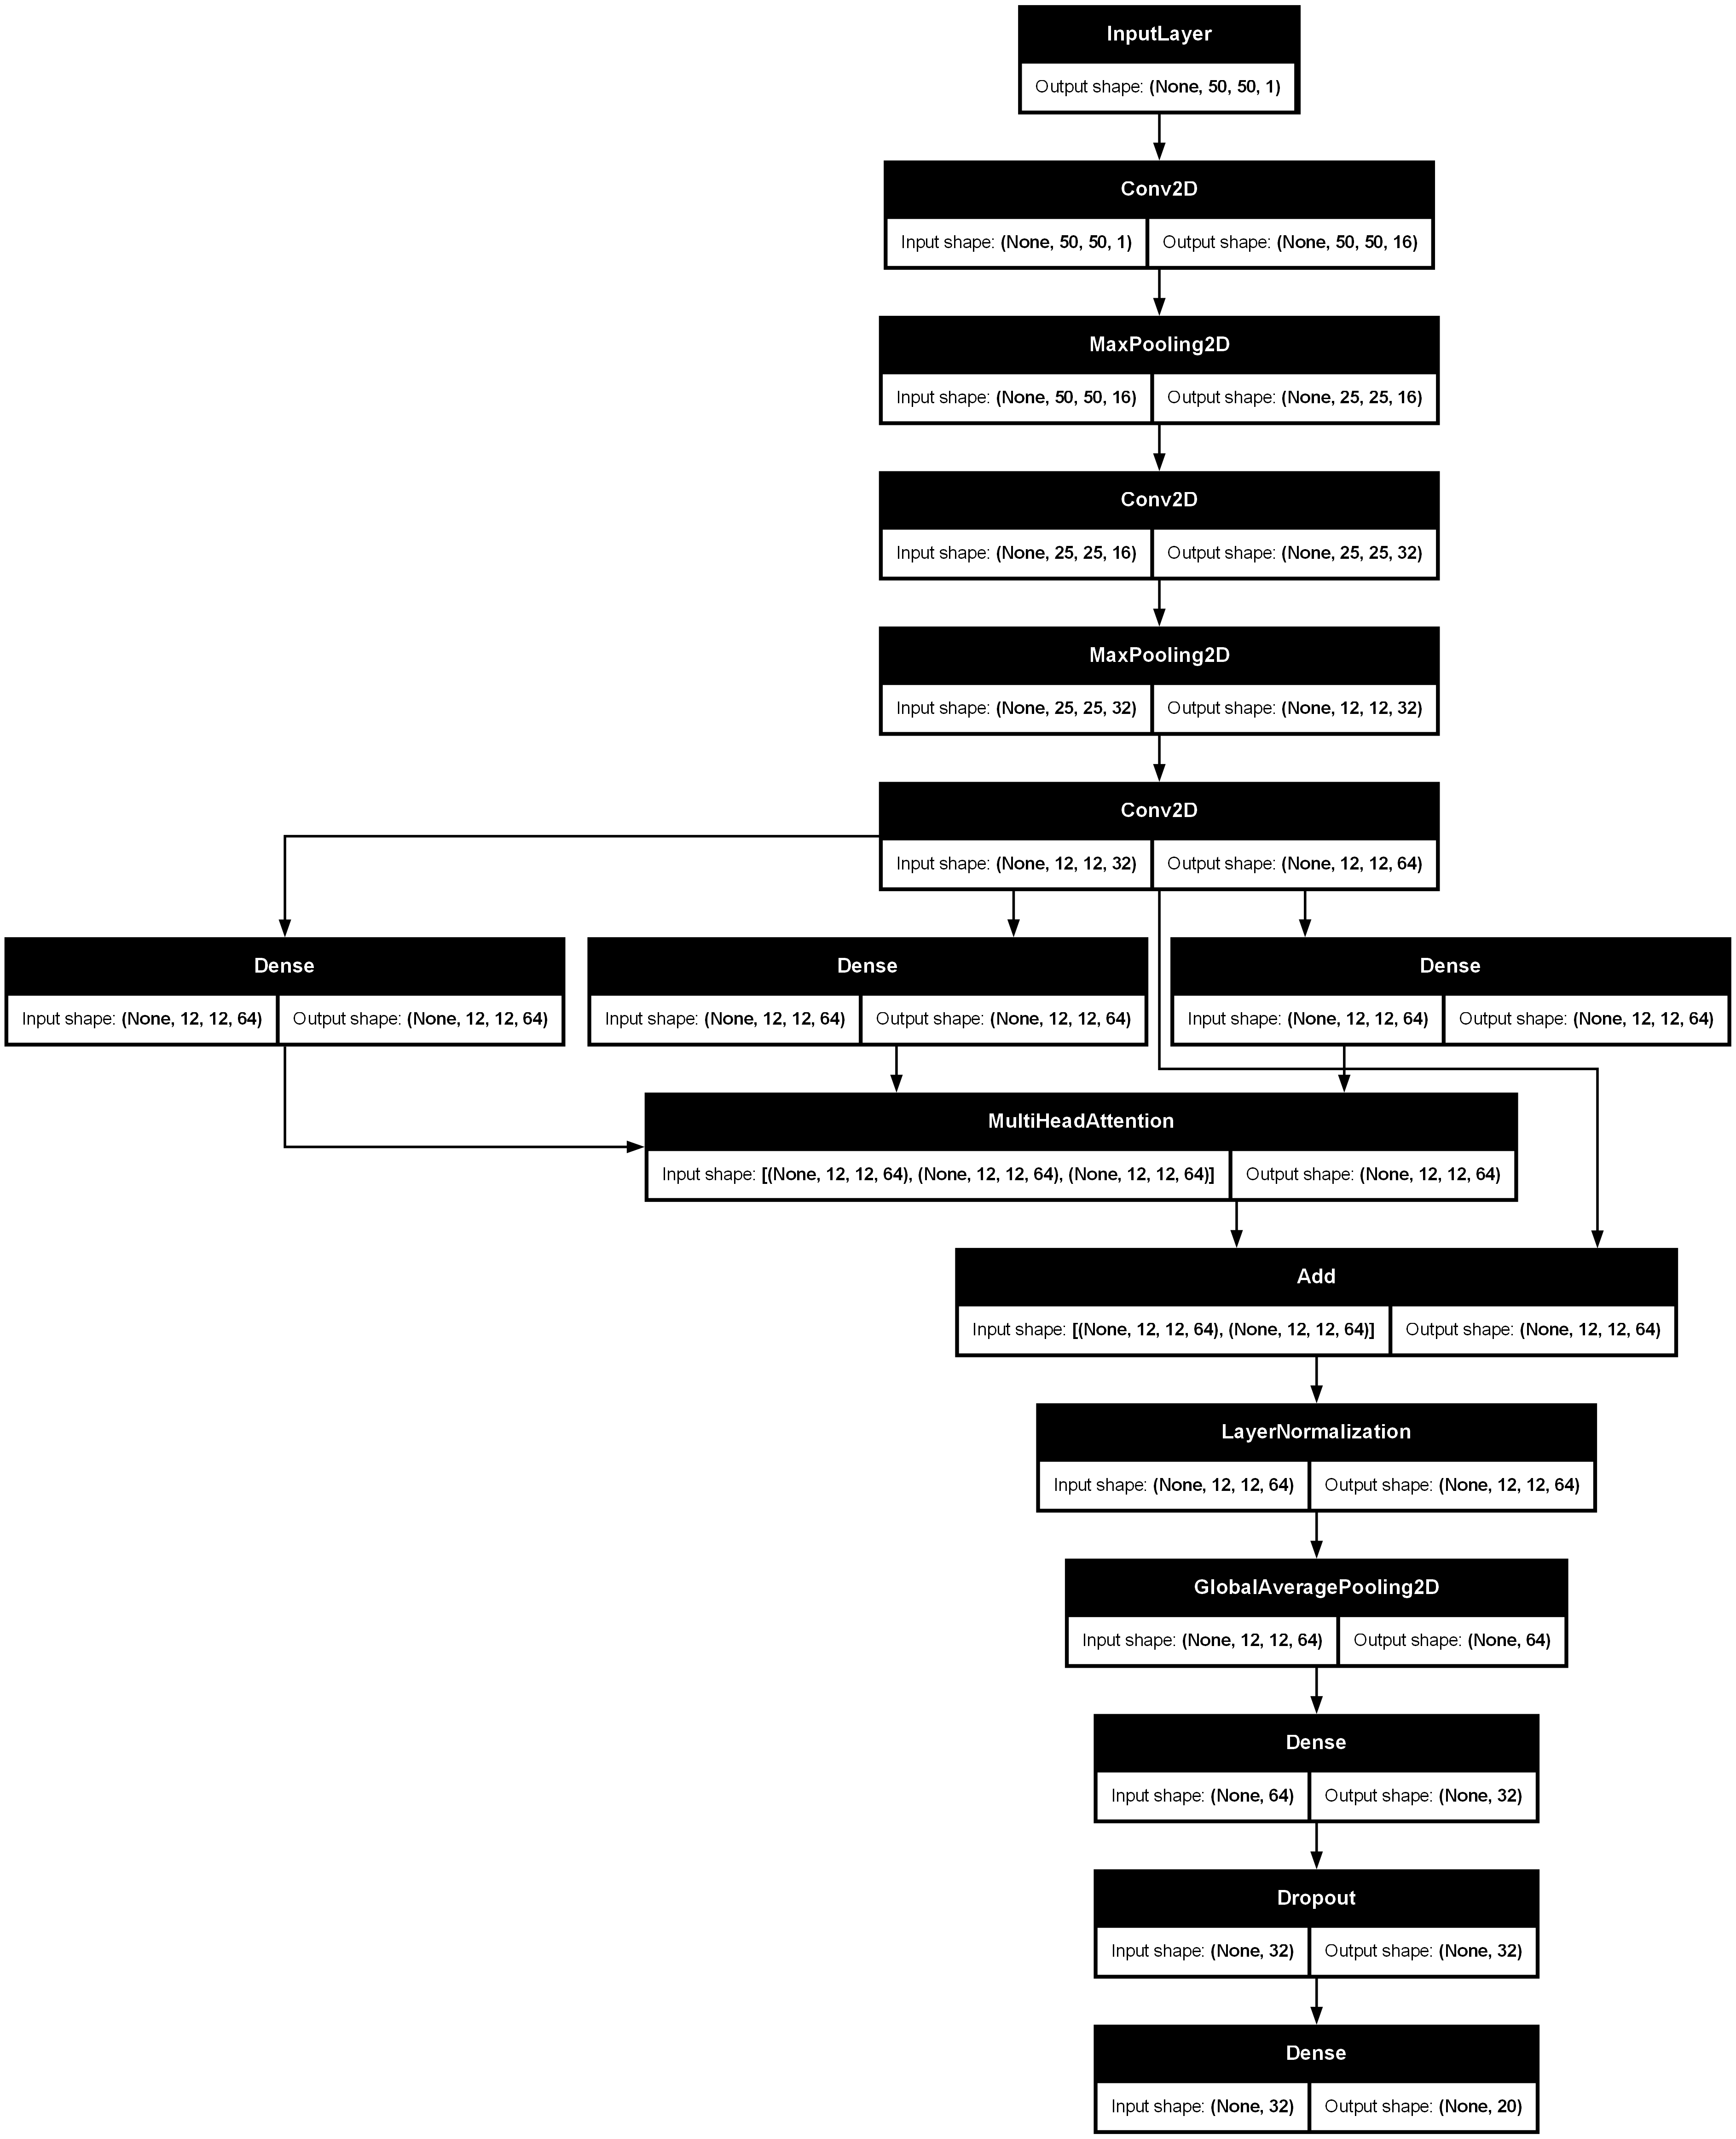

In [33]:
input_layer = Input(shape=(50,50,1,))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = attention_block(x)
x = GlobalAveragePooling2D()(x)

x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)

output_layer = Dense(20, activation='softmax')(x)

CNN = Model(inputs=[input_layer],outputs=[output_layer])
CNN.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
import tensorflow as tf
tf.keras.utils.plot_model(CNN, show_shapes=True)

In [145]:
batch_size = 32
steps_per_epoch = x_train.shape[0] // batch_size

CNN.fit(datagen.flow(x_train, y_train, batch_size=batch_size), validation_data=(x_test, y_test), epochs=500, steps_per_epoch=steps_per_epoch, callbacks=[save_callback])

Epoch 1/500


D:\Users\crash\anaconda3\envs\DeepLearning\lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_291']
Received: inputs=Tensor(shape=(None, 50, 50, 1))
  warnings.warn(msg)


449/450 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1057 - loss: 2.7902
Epoch 1: Saving model weights with loss=2.4333 and val_loss=2.2817
450/450 ━━━━━━━━━━━━━━━━━━━━ 26s 52ms/step - accuracy: 0.1060 - loss: 2.7886 - val_accuracy: 0.1231 - val_loss: 2.2817
Epoch 2/500
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4025 - loss: 1.5461
Epoch 2: Saving model weights with loss=1.3727 and val_loss=1.6457
450/450 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.4026 - loss: 1.5457 - val_accuracy: 0.3111 - val_loss: 1.6457
Epoch 3/500
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6238 - loss: 0.9789
Epoch 3: Saving model weights with loss=0.8862 and val_loss=0.9216
450/450 ━━━━━━━━━━━━━━━━━━━━ 23s 52ms/step - accuracy: 0.6239 - loss: 0.9787 - val_accuracy: 0.6058 - val_loss: 0.9216
Epoch 4/500
450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7440 - loss: 0.6851
Epoch 4: Saving model weights with loss=0.6334 and val_loss=0.4990
450/450 ━━━━━━━━━━━━━━━━━━━━ 23s 52

KeyboardInterrupt: 

### Own callback to save model weights only when both loss and validation loss are the lowest

In [ ]:
import keras
from keras.callbacks import Callback
import os

class SaveBestWeights(Callback):
    def __init__(self, filepath):
        super(SaveBestWeights, self).__init__()
        self.filepath = filepath
        self.best_loss = float('inf')
        self.best_val_loss = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current_loss = logs.get('loss')
        current_val_loss = logs.get('val_loss')
        
        if current_loss <= self.best_loss and current_val_loss <= self.best_val_loss:
            self.best_loss = current_loss
            self.best_val_loss = current_val_loss
            print(f"\nEpoch {epoch+1}: Saving model weights with loss={current_loss:.4f} and val_loss={current_val_loss:.4f}")
            self.model.save_weights(self.filepath)

save_callback = SaveBestWeights(filepath='20gesturesx50Old.weights.h5')

In [10]:
CNN.load_weights("gesturesBest.weights.h5")

D:\Users\crash\anaconda3\envs\DeepLearning\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 54 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [13]:
valx, valy, valclasses_map = load_images_from_folder("test", target_size=(50, 50))
x_val = valx.reshape(-1, 50, 50, 1)
y_val = to_categorical(valy, len(valclasses_map))

test_loss, test_acc = CNN.evaluate(x_val, y_val, verbose=2)
print(f"Test accuracy: {test_acc * 100:.2f}%")

D:\Users\crash\anaconda3\envs\DeepLearning\lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_6']
Received: inputs=Tensor(shape=(None, 50, 50, 1))
  warnings.warn(msg)


188/188 - 7s - 35ms/step - accuracy: 0.9897 - loss: 0.0477
Test accuracy: 98.97%


## Final results

In [26]:
print("98.97% accuracy for test set separated by dataset creator with", x_val.shape[0], "samples")
print("99.72% accuracy for validation set separated from train set during training for", x_test.shape[0], "samples")
print("98.40% accuracy for train set brought from dataset with", x_train.shape[0], "samples")

98.97% accuracy for test set separated by dataset creator with 6000 samples
99.72% accuracy for validation set separated from train set during training for 3600 samples
98.40% accuracy for train set brought from dataset with 14400 samples
